In [1]:
!pip install contractions
!pip install config

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 11.0 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import contractions
import nltk
nltk.download('omw-1.4')
#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import accuracy_score
# from numpy import mean
# from numpy import std

#remove stop words
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
import re

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/malware-ransomware-spam/ransomware.xlsx
/kaggle/input/malware-ransomware-spam/spam.xlsx
/kaggle/input/malware-ransomware-spam/malware.xlsx
/kaggle/input/cve-data-by-type/cve_data_by_type.csv


In [3]:
multiclass = pd.read_csv('/kaggle/input/cve-data-by-type/cve_data_by_type.csv')

In [4]:
multiclass.columns

Index(['Unnamed: 0', 'CVE ID', 'CWE ID', '# of Exploits',
       'Vulnerability Type(s)', 'Publish Date', 'Update Date', 'Score',
       'Gained Access Level', 'Access', 'Complexity', 'Authentication',
       'Conf.', 'Integ.', 'Avail.', 'full_text'],
      dtype='object')

In [5]:
import plotly.graph_objs as go

# Compute value counts for the label column
counts = multiclass['Vulnerability Type(s)'].value_counts()

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Training Set', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white')

# Show the plot
fig.show()

Text pre-processing

In [6]:
def data_save(data_to_u2v):
    data_to_u2v['tweet_id'] = data_to_u2v['tweet_id'].astype(str)
    data_to_u2v['conversation_id'] = data_to_u2v['conversation_id'].astype(str)
    data_to_u2v['author_id'] = data_to_u2v['author_id'].astype(str)
    return data_to_u2v

In [7]:
def big_clean(data):
    data['full_text_clean'] = data['full_text']
    data['full_text_clean'] = data['full_text_clean'].apply(clean_text)
    data['full_text_clean'] = data['full_text_clean'].apply(remove_stop_words)
    return data

In [8]:
# # apply
# big_clean(multiclass)
# multiclass.head()

menaging labels

In [9]:
# multiclass['full_text']

In [10]:
malware = pd.read_excel('/kaggle/input/malware-ransomware-spam/malware.xlsx')
data_save(malware)
ransomware = pd.read_excel('/kaggle/input/malware-ransomware-spam/ransomware.xlsx')
data_save(ransomware)
spam = pd.read_excel('/kaggle/input/malware-ransomware-spam/spam.xlsx')
data_save(spam)
malware['Vulnerability Type(s)'] = malware['label']
ransomware['Vulnerability Type(s)'] = ransomware['label']
spam['Vulnerability Type(s)'] = spam['label']



In [11]:
spam

,Unnamed: 0,index,Unnamed: 0.1,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,...,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version,tweet_id,full_text,label,full_text_clean,pred_model%_1,Vulnerability Type(s)
0,41613,42159,42159,1.650482e+18,1650459899015356417,1.650460e+18,NaN,NaN,22575419,4.009993e+08,...,NaN,2023-04-27T16:12:11+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1650482497384247301,@MrsLalupa Hay apps que te avisan de los númer...,spam,apps avisan numeros detectados spam nno movil ...,0.999957,spam
1,18802,19006,19006,1.651100e+18,1651100211471630336,NaN,NaN,NaN,1073764029590589440,NaN,...,NaN,2023-04-27T16:05:11+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1651100211471630336,i need to buy more fake meat spam im craving i...,spam,fake meat spam craving,0.999732,spam
2,51925,52585,52585,1.650157e+18,1650156884467539975,NaN,NaN,NaN,18429446,NaN,...,NaN,2023-04-27T16:17:54+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1650156884467539975,now have to try to prompt inject the random sp...,spam,prompt inject random spam whatsapp,0.999681,spam
3,59627,60360,60360,1.649885e+18,1649766310849413121,1.649885e+18,NaN,NaN,1383744141251661828,7.392349e+17,...,NaN,2023-04-27T16:20:22+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649885286011109379,@AngOlmo @annitaabenojar @SMNHI @Jero20033756 ...,spam,activado spam cojo llamada,0.999615,spam
4,16569,16747,16747,1.651175e+18,1651175190527721476,NaN,NaN,NaN,1540930489556602881,NaN,...,NaN,2023-04-27T16:04:31+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1651175190527721476,minha mãe fez um spam com minha cara no instag...,spam,mae spam instagram serio preocupante,0.999589,spam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,30235,30644,30644,1.650791e+18,1650787556936523777,1.650788e+18,NaN,NaN,1648889428746596352,1.364600e+18,...,NaN,2023-04-27T16:08:41+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1650790968428249088,@_NEM00_ engel spam cimer,spam,engel spam cimer,0.979989,spam
1996,20890,21148,21148,1.651032e+18,1650993524328857605,1.650994e+18,NaN,NaN,56572607,1.228070e+18,...,NaN,2023-04-27T16:05:50+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1651031856530300929,@CeezyStill I gotta report this page for spam wow,spam,report spam wow,0.979979,spam
1997,68269,69129,69129,1.649602e+18,1649590910882050054,1.649600e+18,NaN,NaN,1480652644880424960,1.291557e+18,...,NaN,2023-04-27T16:23:06+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649601566884745216,@stephany_bts7 Cuando sucedio el problema de l...,spam,sucedio problema infidelidad dios cayeron mosc...,0.979976,spam
1998,59910,60645,60645,1.649877e+18,1649876816256016385,NaN,NaN,NaN,1370635766263644162,NaN,...,NaN,2023-04-27T16:20:28+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649876816256016385,Cada que bloqueo su puto número me empeiza el ...,spam,bloqueo puto numero empeiza puto spam mierda,0.979962,spam


In [12]:
multiclass0 = pd.concat([multiclass, malware, ransomware, spam])
data_save(multiclass0)
# multiclass.reset_index(inplace=True)
multiclass0.reset_index(inplace=True, drop=True)
multiclass0['full_text']

0        Cacti is an open source platform which provide...
1        Prometheus Exporter Toolkit is a utility packa...
2        CrowdStrike Falcon 6.44.15806 allows an admini...
3        An authentication bypass in Lin-CMS v0.2.1 all...
4        An issue was discovered in BACKCLICK Professio...
                               ...                        
30179                            @_NEM00_ engel spam cimer
30180    @CeezyStill I gotta report this page for spam wow
30181    @stephany_bts7 Cuando sucedio el problema de l...
30182    Cada que bloqueo su puto número me empeiza el ...
30183    @ACarthaginensis @EduNoirrak Y más… 😊 (y ya pa...
Name: full_text, Length: 30184, dtype: object

In [13]:
data_classes = ["Overflow","DoS","gain_privileges","Memory_Corruption","bypass","CSRF","Gain_info","sql_injection","XSS","Dir_traversal","Exec_code","File_inclusion", "ransomware", "malware", "spam"]

d = dict(zip(data_classes, range(0,15)))
d

{'Overflow': 0,
 'DoS': 1,
 'gain_privileges': 2,
 'Memory_Corruption': 3,
 'bypass': 4,
 'CSRF': 5,
 'Gain_info': 6,
 'sql_injection': 7,
 'XSS': 8,
 'Dir_traversal': 9,
 'Exec_code': 10,
 'File_inclusion': 11,
 'ransomware': 12,
 'malware': 13,
 'spam': 14}

In [14]:
multiclass0['label'] = multiclass0['Vulnerability Type(s)'].map(d, na_action='ignore')
multiclass0

,Unnamed: 0,CVE ID,CWE ID,# of Exploits,Vulnerability Type(s),Publish Date,Update Date,Score,Gained Access Level,Access,...,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version,tweet_id,label,full_text_clean,pred_model%_1
0,0,CVE-2022-46169,77.0,NaN,bypass,12/5/2022,12/6/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
1,1,CVE-2022-46146,287.0,NaN,bypass,11/29/2022,12/5/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
2,2,CVE-2022-44721,863.0,NaN,bypass,12/4/2022,12/6/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
3,3,CVE-2022-44244,287.0,NaN,bypass,11/9/2022,11/17/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
4,4,CVE-2022-44001,306.0,NaN,bypass,11/17/2022,11/18/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30179,30235,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:08:41+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1650790968428249088,14,engel spam cimer,0.979989
30180,20890,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:05:50+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1651031856530300929,14,report spam wow,0.979979
30181,68269,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:23:06+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649601566884745216,14,sucedio problema infidelidad dios cayeron mosc...,0.979976
30182,59910,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:20:28+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649876816256016385,14,bloqueo puto numero empeiza puto spam mierda,0.979962


In [15]:
data_save(multiclass0)

#save the cleanned text in the new cvs file
# multiclass.to_excel('multiclass_dataset.xlsx', encoding = 'utf-8')

,Unnamed: 0,CVE ID,CWE ID,# of Exploits,Vulnerability Type(s),Publish Date,Update Date,Score,Gained Access Level,Access,...,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version,tweet_id,label,full_text_clean,pred_model%_1
0,0,CVE-2022-46169,77.0,NaN,bypass,12/5/2022,12/6/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
1,1,CVE-2022-46146,287.0,NaN,bypass,11/29/2022,12/5/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
2,2,CVE-2022-44721,863.0,NaN,bypass,12/4/2022,12/6/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
3,3,CVE-2022-44244,287.0,NaN,bypass,11/9/2022,11/17/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
4,4,CVE-2022-44001,306.0,NaN,bypass,11/17/2022,11/18/2022,0.0,None,???,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30179,30235,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:08:41+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1650790968428249088,14,engel spam cimer,0.979989
30180,20890,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:05:50+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1651031856530300929,14,report spam wow,0.979979
30181,68269,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:23:06+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649601566884745216,14,sucedio problema infidelidad dios cayeron mosc...,0.979976
30182,59910,NaN,NaN,NaN,spam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-27T16:20:28+00:00,https://api.twitter.com/2/tweets/search/recent...,2.14.0,1649876816256016385,14,bloqueo puto numero empeiza puto spam mierda,0.979962


In [16]:
!pip install stopwordsiso
import stopwordsiso
from stopwordsiso import stopwords
stopwords = stopwords(['af', 'ar', 'hy', 'eu', 'bn', 'br', 'bg', 'ca', 'zh', 'hr', 'cs', 'da', 'nl', 'en', 'eo', 'et', 'fi', 'fr', 'gl', 'de', 'el', 'gu', 'ha', 'he', 'hi', 'hu', 'id', 'ga', 'it', 'ja', 'ko', 'ku', 'la', 'lt', 'lv', 'ms', 'mr', 'no', 'fa', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'so', 'st', 'es', 'sw', 'sv', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'yo', 'zu'])  # German, Indonesian, and Chinese stopwords
# Removing stop words
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

#not removing the whole word because it can signalize #vulnerability #cyberattack, etc
def remove_hashtag(text):
    return re.sub(r'#', '', text)

def remove_dog(text):
    return re.sub(r'@\w+', '', text)

def remove_punctuations(text):
    return re.sub('\[[^]]*\]!?.,:;', '', text)

def remove_characters(text):
    return re.sub(r'[^\w\s]', ' ', text)

from unidecode import unidecode
def remove_diacritics(text):
    return unidecode(text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_urls(text):
    return re.sub(r'https:\S+', '', text)

def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

#defining the object for Lemmatization
lemmatizer = WordNetLemmatizer()
#defining a function for lemming
def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#         u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
#         u"\U000024C2-\U0001F251" this removes japanesse chr
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

def clean_text(text):
    text = remove_url(text)
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_dog(text)
    text = remove_contractions(text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)# - this is good only for latin alphabets
    text = lemmatize_words(text)
    text = remove_emojis(text)
    text = remove_diacritics(text)
    return text

import nltk
from nltk.stem import SnowballStemmer

# Initialize the Snowball stemmers for all available languages
nltk.download('snowball_data')
languages = {
    'ar': 'arabic',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'fi': 'finnish',
    'fr': 'french',
    'de': 'german',
    'hu': 'hungarian',
    'it': 'italian',
    'no': 'norwegian',
    'porter': 'porter',
    'pt': 'portuguese',
    'ro': 'romanian',
    'ru': 'russian',
    'es': 'spanish',
    'sv': 'swedish'
}


# Stemming function that applies stemming based on the language
def stem_text(text, language):
    if language in languages:
        stemmer = SnowballStemmer(languages[language.lower()])
        return ' '.join([stemmer.stem(word) for word in text.split()])
    else:
        return text
    


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.8 MB/s eta 0:00:00


[nltk_data] Downloading package snowball_data to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


In [17]:
multiclass0 = pd.DataFrame(multiclass0)
multiclass0['full_text_clean'] = multiclass0['full_text']
multiclass0['full_text_clean'] = multiclass0['full_text_clean'].apply(clean_text)
multiclass0['full_text_clean'] = multiclass0['full_text_clean'].apply(remove_stop_words)
multiclass0['full_text_clean']

0        cactus source platform robust extensible opera...
1        prometheus exporter toolkit utility package bu...
2        crowdstrike falcon 44 15806 administrative att...
3        authentication bypass v0 attacker escalate pri...
4        issue discovered backclick professional 63 use...
                               ...                        
30179                                     engel spam cimer
30180                                      report spam wow
30181    sucedio problema infidelidad dios cayeron mosc...
30182         bloqueo puto numero empeiza puto spam mierda
30183                                            paro spam
Name: full_text_clean, Length: 30184, dtype: object

In [18]:
# Apply stemming to the dataset
multiclass0['full_text_clean'] = multiclass0.apply(lambda row: stem_text(row['full_text_clean'], row['lang']), axis=1)

In [19]:
counts = multiclass0['Vulnerability Type(s)'].value_counts()
# Get the number of classes
num_classes = len(counts)
print(num_classes)
# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Labels Distribution in Training Set', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white')

# Show the plot
fig.show()

15


In [20]:
import collections
# Counting the number of words
from collections import Counter
stop_words = stopwords


In [21]:
def word_occurance(label):
    
    d0 = multiclass0.loc[multiclass0['label']==label, 'full_text_clean'].tolist()
    d0_text = ' '.join(d0).split()
    d00 = []
    for r in d0_text:
        if not r in stop_words:
            d00.append(r) 
    topd0 = Counter(d00)
    topd0 = topd0.most_common(20)
    plt.bar(range(len(topd0)), [val[1] for val in topd0], align='center')
    plt.xticks(range(len(topd0)), [val[0] for val in topd0])
    plt.xticks(rotation=70)
    plt.title((list(d.keys())[list(d.values()).index(label)]))
    plt.show()

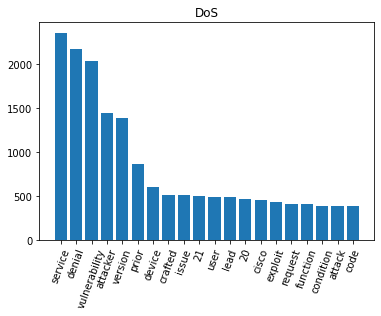

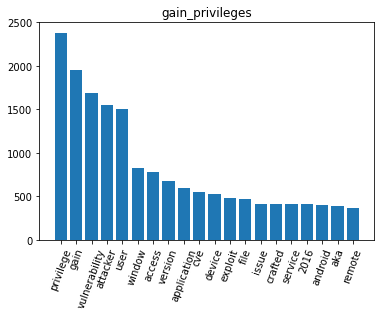

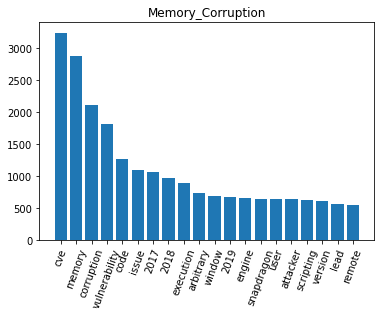

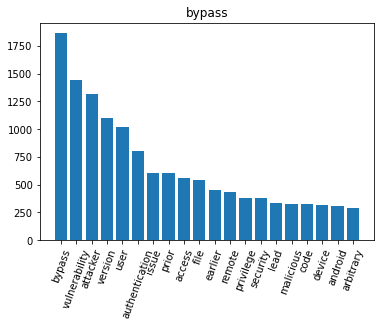

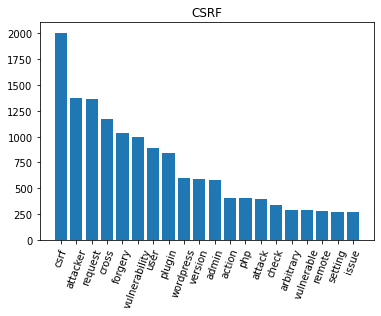

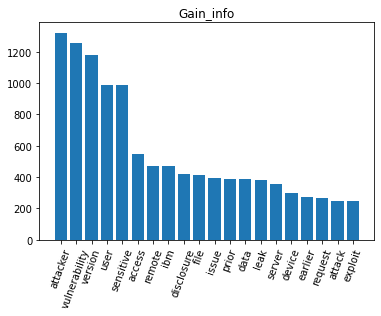

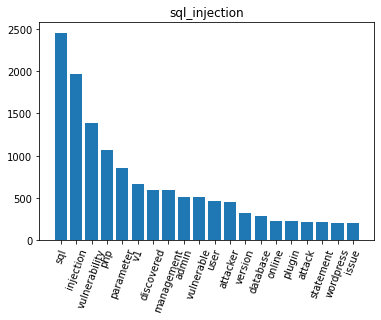

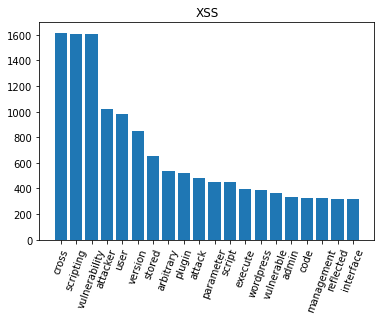

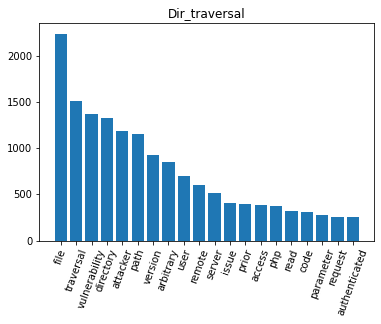

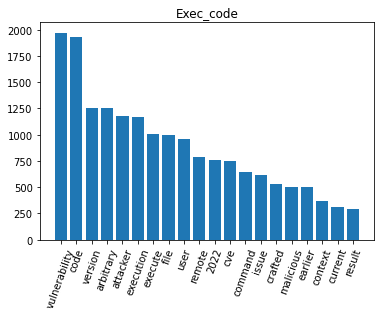

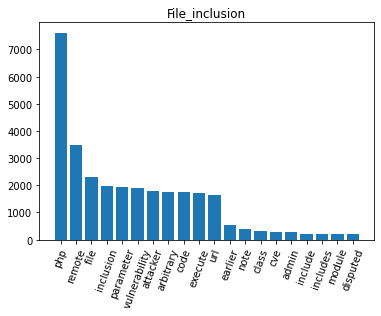

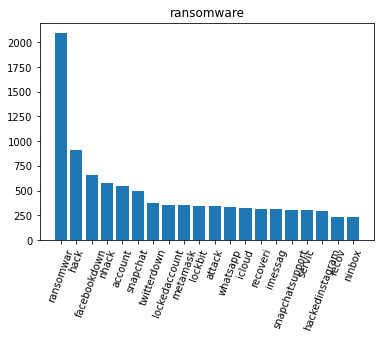

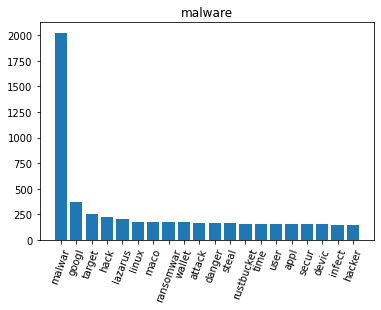

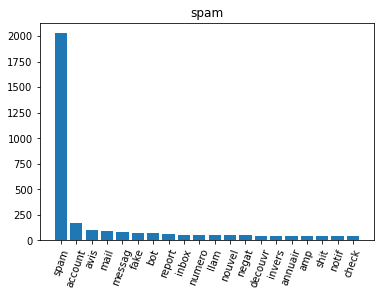

In [22]:
for i in range (1,len(data_classes)):
    word_occurance(i)


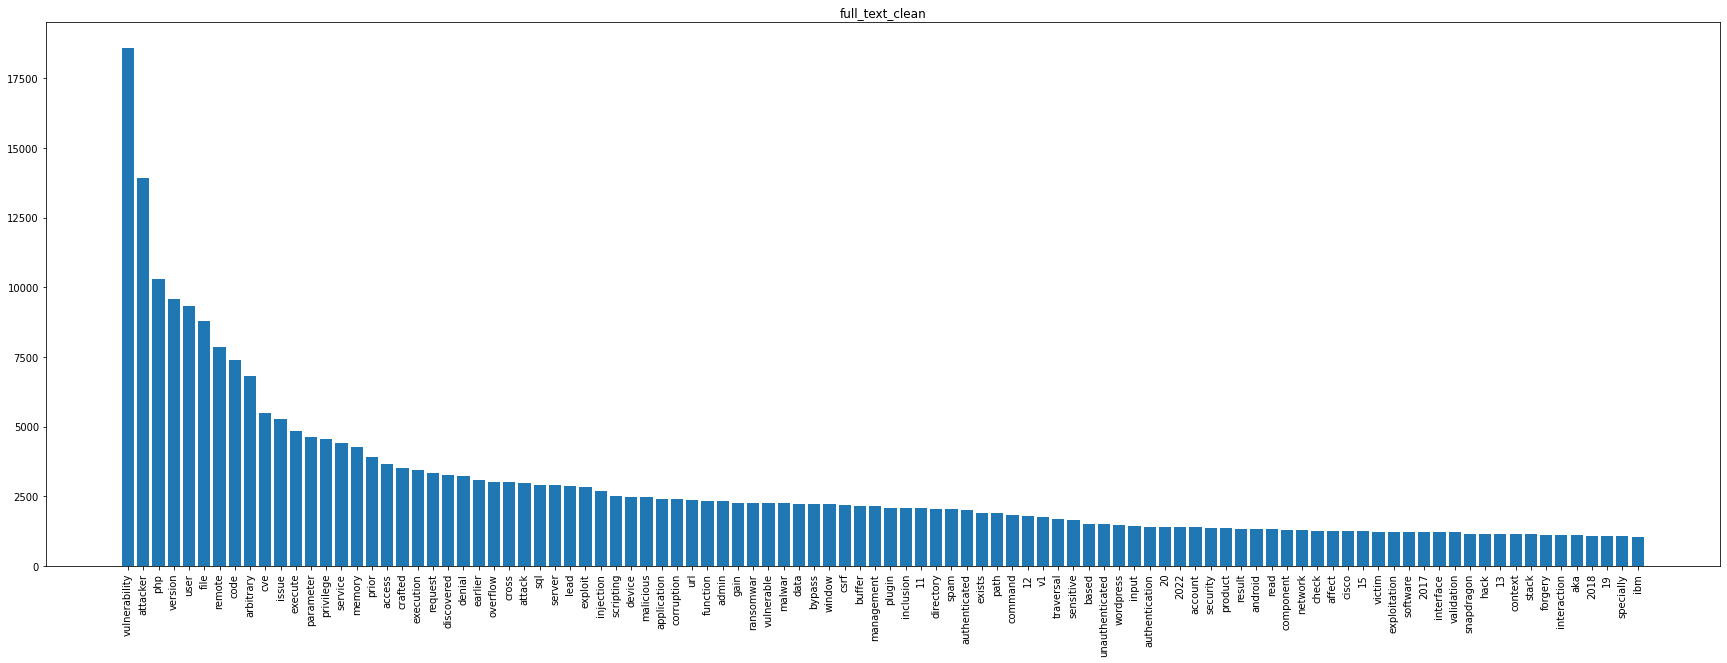

In [23]:
    d0 = multiclass0['full_text_clean'].tolist()
    d0_text = ' '.join(d0).split()
    d00 = []
    for r in d0_text:
        if not r in stop_words:
            d00.append(r) 
    topd0 = Counter(d00)
    topd0 = topd0.most_common(100)
    
    plt.rcParams["figure.figsize"] = (30,10)

    plt.bar(range(len(topd0)), [val[1] for val in topd0], align='center')
    plt.xticks(range(len(topd0)), [val[0] for val in topd0])
    plt.xticks(rotation=90)
    plt.title('full_text_clean')
    plt.show()

In [24]:
multiclass0 = pd.DataFrame(multiclass0)
multiclass0['full_text_clean']

0        cactus source platform robust extensible opera...
1        prometheus exporter toolkit utility package bu...
2        crowdstrike falcon 44 15806 administrative att...
3        authentication bypass v0 attacker escalate pri...
4        issue discovered backclick professional 63 use...
                               ...                        
30179                                     engel spam cimer
30180                                      report spam wow
30181    sucedi problem infidel dios cayeron mosc spam ...
30182               bloque put numer empeiz put spam mierd
30183                                             par spam
Name: full_text_clean, Length: 30184, dtype: object

In [25]:
# Filter the DataFrame
multiclass1 = multiclass0[multiclass0['full_text_clean'].str.split().str.len() >= 4]
multiclass1 = multiclass1.reset_index(drop=True)


In [26]:
multiclass1['full_text_clean']

0        cactus source platform robust extensible opera...
1        prometheus exporter toolkit utility package bu...
2        crowdstrike falcon 44 15806 administrative att...
3        authentication bypass v0 attacker escalate pri...
4        issue discovered backclick professional 63 use...
                               ...                        
29543            oig hag product report spam got haz igual
29544       vlada posilja vsiljeno spam etovaneu novinarju
29545               emailmarket googl workspac spam folder
29546    sucedi problem infidel dios cayeron mosc spam ...
29547               bloque put numer empeiz put spam mierd
Name: full_text_clean, Length: 29548, dtype: object

> Embedd the words

In [27]:
!pip install -q laserembeddings laserembeddings[zh] laserembeddings[ja]
!pip install -q ftfy

important libs for the embeddings

In [28]:
!pip install fastcache
# import fasttext
import ftfy
import html
import laserembeddings
import sys

from fastcache import clru_cache
from laserembeddings import Laser
from typing import List, Union
from urllib.parse import unquote

  Preparing metadata (setup.py) ... - done
  Created wheel for fastcache: filename=fastcache-1.1.0-cp37-cp37m-linux_x86_64.whl size=46644 sha256=b628e0d72735c5a927e5fd188092c8a7d9d70d90bc98798455749018326b4fb1
  Stored in directory: /root/.cache/pip/wheels/ed/3a/69/4ac4d0d090ee49ab41ce5369f57f8f219f82b541de50a80ea9
Successfully built fastcache


LASER Embeddings This encodes each of the strings as a LASER embedding (1024 dimentional vector)

In [29]:
%%bash
# DOCS: https://github.com/facebookresearch/LASER/blob/master/install_models.sh
mkdir -p models/laser/
# for FILE in bilstm.eparl21.2018-11-19.pt eparl21.fcodes eparl21.fvocab bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
for FILE in bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
    wget -cq https://dl.fbaipublicfiles.com/laser/models/$FILE -O models/laser/$FILE
done

In [30]:
#from src.utils.fasttest_model import language_detect
# from src.utils.punkt_tokenizer import punkt_tokenize_sentences
config = {
    "laser": {
        "base_dir":  "./models/laser",
        "bpe_codes": "./models/laser/93langs.fcodes",
        "bpe_vocab": "./models/laser/93langs.fvocab",
        "encoder":   "./models/laser/bilstm.93langs.2018-12-26.pt",
    }
}

In [31]:
# Instantiate encoder
# BUG: CUDA GPU memory is exceeded if both laser and labse are loaded together 
# @clru_cache(None)
def get_laser_model():
    laser_model = Laser(
        bpe_codes = config['laser']['bpe_codes'],
        bpe_vocab = config['laser']['bpe_vocab'],
        encoder   = config['laser']['encoder'],
        tokenizer_options = None,
        embedding_options = None
    )
    return laser_model

def laser_encode(text: Union[str, List[str]], lang='autodetect', normalize=True) -> np.ndarray:
    """
    Encodes a corpus of text using LASER
    :param text: Large block of text (will be tokenized), or list of pre-tokenized sentences
    :param lang: 2 digit language code (optional autodetect)
    :return:     embedding matrix
    """
    laser_model = get_laser_model()
    
    if isinstance(text, str):
        # sentences = punkt_tokenize_sentences(text, lang=lang)
        sentences = ['text']

    else:
        sentences = list(text)

    embedding = laser_model.embed_sentences(sentences, lang=lang)
    
    if normalize:
        embedding = embedding / np.sqrt(np.sum(embedding**2, axis=1)).reshape(-1,1)
        
    return embedding

> build the train-validation-test datasets

In [32]:
from sklearn.model_selection import train_test_split


In [33]:
X_train =laser_encode(multiclass1['full_text_clean'])
y_train = multiclass1['label']

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)

> Multi-Label Classification
to configure a neural network model for multi-label classification, the specifics are:

* Number of nodes in the output layer matches the number of labels.
* Sigmoid activation for each node in the output layer.
* Binary cross-entropy loss function.

In [34]:
# seed initialization
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
batch_size = 64


In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8)
import time
class TrainingTimeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        print("Training time:", elapsed_time, "seconds")
        training_time.append(elapsed_time)

In [36]:
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_score_list = []
auc_roc_list = []
mcc_list = []
model_name = []
training_time = []

In [37]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report
# Compute confusion matrix
def confusion(predictions):
    cm = confusion_matrix(y_test1, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()
    
    # Print confusion matrix
    classes = np.unique(y_test1)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test1, predictions, target_names=[f"label {c}" for c in classes]))
    
    auc_roc = roc_auc_score(y_test1, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test1, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, predictions, average='macro')
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    auc_roc_list.append(auc_roc)
    mcc_list.append(mcc)
    model_name.append(m)

def results(model, x, y, x_t, y_t):    
    print('Train Accuracy: ')
    model.evaluate(x, y, verbose =1)

    print('Test Accuracy: ')
    loss, accuracy = model.evaluate(x_t , y_t , verbose =1)
    # Print the evaluation results
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    
    prediction = model.predict(x_t)
    for i in range(len(prediction)):
        if (prediction[i] < 0.5):
            prediction[i] = 0
        else: 
            prediction[i] = 1
    confusion(prediction)

In [38]:
batch_size = 64
# Initialize counter for saved models
num_saved_models = 1
# epochs = 200
max_len = 1024
import contractions
import nltk
nltk.download('omw-1.4')
#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import collections
# Counting the number of words
from collections import Counter
import time

import tabulate
from tabulate import tabulate

#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.layers import Embedding, Input, Dense
from keras.models import Model

import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn import preprocessing

import nltk # NLP  
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import re  

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from tensorflow.keras import regularizers

#Tuner
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
# cross validation and metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer
from unidecode import unidecode
from keras_tuner.tuners import RandomSearch

#metrics:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
        

def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax),
    ])
    model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
    print(model.summary())
    return model


def model_fit(model,x, y, x_v, y_v):
    global num_saved_models, m
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
    history = model.fit(x, y, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2, 
                        validation_data=([x_v,y_v]),
                        verbose=0,
                        callbacks=[callback,TrainingTimeCallback()])
    
    model.save(f"model_{m}_{num_saved_models}.h5")
    
    # Increment the counter for saved models
    num_saved_models += 1

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



In [39]:
epochs = 250
for i in range(0, 1):
    # train - validation split:
    X_train1, X_val1, y_train1, y_val1  = train_test_split(X_train, y_train, test_size=0.30, random_state=0)
    X_val1, X_test1, y_val1, y_test1  = train_test_split(X_val1, y_val1, test_size=0.50, random_state=0)
    print(X_train1.shape)
    print(X_val1.shape)
    m = 'multiclass_laser'
    model1 = build_model(1024)
    model_fit(model1, X_train1, y_train1, X_val1, y_val1)
#     results(model1, X_train1, y_train1, X_test1, y_test1)
    i += 1

(20683, 1024)
(4432, 1024)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              

In [40]:
# history = model.fit(X_train, y_train, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     validation_split=0.2, 
#                     verbose=0,
#                     validation_data=([X_val, y_val]),
#                     callbacks=callback)

In [41]:
# data = {
#     "Model": model_name,
#     "Accuracy": accuracy_list,
#     "Loss": loss_list,
#     "Precision": precision_list,
#     "Recall": recall_list,
#     "F1 Score": f1_score_list,
#     "AUC-ROC": auc_roc_list,
#     "MCC": mcc_list,
#     "Training time":training_time

# }

# df = pd.DataFrame(data)
# print(df)

In [42]:
# df.to_excel('multiclass_results.xlsx', index=False, encoding='utf-8-sig')


In [43]:
# grouped_results = df.reset_index().groupby('Model').mean().sort_values('index')
# grouped_results = grouped_results.drop('index', axis=1)

# grouped_results.reset_index(level=0, inplace=True)
# grouped_results

In [44]:
output = model1.predict(X_test1)
# with np.printoptions(threshold=np.inf):
#     print(output)

output

array([[1.75439741e-03, 3.98206990e-03, 3.02016493e-02, ...,
        1.00736124e-02, 9.97134484e-03, 1.08539062e-02],
       [1.73665266e-02, 1.95897687e-02, 4.20961325e-04, ...,
        6.21482823e-03, 7.77247071e-04, 2.06086217e-04],
       [5.13592316e-03, 1.54164657e-02, 3.19415554e-02, ...,
        3.33726493e-04, 7.33607973e-04, 8.60413849e-01],
       ...,
       [4.11818823e-04, 2.35161558e-03, 1.19759172e-01, ...,
        3.50369629e-03, 3.46983224e-03, 1.29120415e-02],
       [5.50969504e-04, 2.10160296e-03, 1.26532856e-02, ...,
        1.94301642e-03, 1.56734721e-03, 1.00023532e-02],
       [2.43928912e-03, 3.87191609e-03, 5.63593674e-03, ...,
        3.90561260e-02, 3.19621786e-02, 3.28774517e-03]], dtype=float32)

In [45]:
# min(output[0])

In [46]:
def process_cm(confusion_mat, i=0, to_print=True):
    # i means which class to choose to do one-vs-the-rest calculation
    # rows are actual obs whereas columns are predictions
    TP = confusion_mat[i,i]  # correctly labeled as i
    FP = confusion_mat[:,i].sum() - TP  # incorrectly labeled as i
    FN = confusion_mat[i,:].sum() - TP  # incorrectly labeled as non-i
    TN = confusion_mat.sum().sum() - TP - FP - FN
    Precision = TP / (TP + FP)
    Recall    = TP / (TP + FN)
    if to_print:
        print('TP: {}'.format(TP))
        print('FP: {}'.format(FP))
        print('FN: {}'.format(FN))
        print('TN: {}'.format(TN))
        print('Precision: {}'.format(Precision))
        print('Recall: {}'.format(Recall))
    return TP, FP, FN, TN

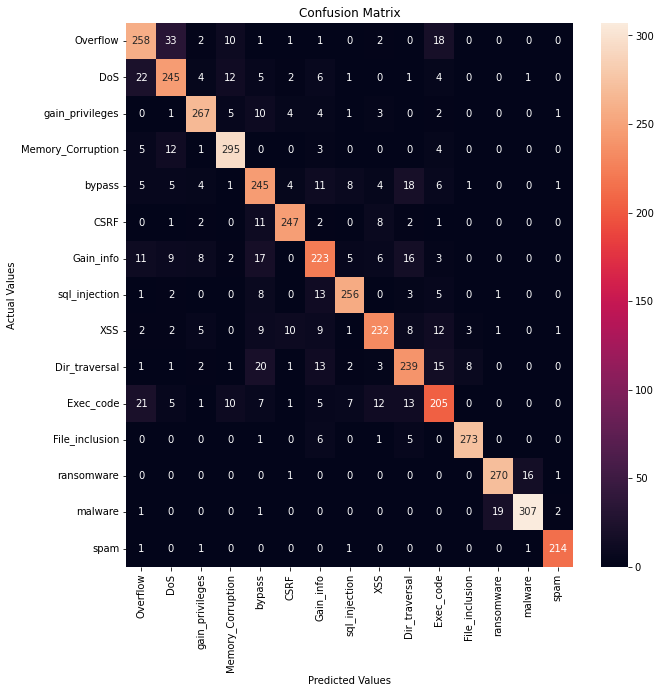

                Label Diagonal Value  Accuracy
0            Overflow            258  0.791411
1                 DoS            245  0.808581
2     gain_privileges            267  0.895973
3   Memory_Corruption            295  0.921875
4              bypass            245  0.782748
5                CSRF            247  0.901460
6           Gain_info            223  0.743333
7       sql_injection            256  0.885813
8                 XSS            232  0.786441
9       Dir_traversal            239  0.781046
10          Exec_code            205  0.714286
11     File_inclusion            273  0.954545
12         ransomware            270  0.937500
13            malware            307  0.930303
14               spam            214  0.981651


In [47]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the confusion matrix
matrix = confusion_matrix(y_test1.argmax(axis=1), output.argmax(axis=1))

# Determine the maximum value in the matrix
max_value = np.max(matrix)

# Get the number of classes
num_classes = len(data_classes)

# Create a square matrix with the maximum value
square_matrix = np.zeros((num_classes, num_classes), dtype=int)
square_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix

# Create a DataFrame from the square matrix
cm_df = pd.DataFrame(square_matrix, columns=data_classes, index=data_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt="d")  # Use 'fmt="d"' to display numbers as integers
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Define the textual labels for each class
textual_labels = data_classes

# Create an empty DataFrame
output_df = pd.DataFrame(columns=['Label', 'Diagonal Value', 'Accuracy'])

# Function to append results to the DataFrame
def append_results(matrix, label):
    diagonal_value = matrix[label, label]
    accuracy = diagonal_value / np.sum(matrix[label, :])
    label_text = textual_labels[label]
    output_df.loc[label] = [label_text, diagonal_value, accuracy]

# Iterate over each label and append results to the DataFrame
for i in range(num_classes):
    append_results(matrix, i)

# Display the DataFrame
print(output_df)

In [48]:
output_df

,Label,Diagonal Value,Accuracy
0,Overflow,258,0.791411
1,DoS,245,0.808581
2,gain_privileges,267,0.895973
3,Memory_Corruption,295,0.921875
4,bypass,245,0.782748
5,CSRF,247,0.901460
6,Gain_info,223,0.743333
7,sql_injection,256,0.885813
8,XSS,232,0.786441
9,Dir_traversal,239,0.781046


In [49]:
import plotly.graph_objs as go

# Get the accuracies and label names
accuracies = output_df['Accuracy']
label_names = output_df['Label']

# Create a bar chart using Plotly
fig = go.Figure(data=[go.Bar(x=label_names, y=accuracies,
                             marker_color='#008B8B',
                             text=[f'{label}: {accuracy:.0%}' for label, accuracy in zip(label_names, accuracies)],
                             textposition='auto')])

# Customize the layout
fig.update_layout(title='Accuracy by Label',
                  xaxis_title='Labels',
                  yaxis_title='Accuracy',
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='#F8F8FF',
                  paper_bgcolor='#F8F8FF',
                  width=1000,
                  height=600)
# Adjust the width of the bars
fig.update_traces(marker=dict(line=dict(width=0.5)))

# Show the plot
fig.show()


In [50]:
mcm = multilabel_confusion_matrix(y_test1.argmax(axis=1), output.argmax(axis=1))
print(mcm)

[[[4037   70]
  [  68  258]]

 [[4059   71]
  [  58  245]]

 [[4105   30]
  [  31  267]]

 [[4072   41]
  [  25  295]]

 [[4030   90]
  [  68  245]]

 [[4135   24]
  [  27  247]]

 [[4060   73]
  [  77  223]]

 [[4118   26]
  [  33  256]]

 [[4099   39]
  [  63  232]]

 [[4061   66]
  [  67  239]]

 [[4076   70]
  [  82  205]]

 [[4135   12]
  [  13  273]]

 [[4124   21]
  [  18  270]]

 [[4085   18]
  [  23  307]]

 [[4209    6]
  [   4  214]]]


In [51]:
# output1=[]
# for i in range(len(output)):
#     o = max(output[i])
#     output1.append(o)


In [52]:
# print('>%.3f' % output[0][9])

In [53]:
# # calculate accuracy
# output2 = output.round()
# output2[22]

In [54]:
# y_test[22]

In [55]:
# # calculate accuracy
# output2 = output2.round()
# acc = accuracy_score(y_test, output2)
# # store result
# print('> %.3f' % acc)
# #results.append(acc)

In [56]:
# with np.printoptions(threshold=np.inf):
#     for i in range(0, len(output)):
#         print('real', y_test[i], 'pred: ', output[i])

In [57]:
model1.save('laser_multiclass_model_16_labels.h5')

In [58]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [59]:
# plot_history(history)

In [60]:
pred=pd.DataFrame(output)
pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.001754,0.003982,0.030202,0.001671,0.015306,0.047910,0.008622,0.536101,0.068175,0.106776,0.017255,0.131346,0.010074,0.009971,0.010854
1,0.017367,0.019590,0.000421,0.021268,0.000794,0.000232,0.001682,0.010733,0.000443,0.009179,0.910054,0.001040,0.006215,0.000777,0.000206
2,0.005136,0.015416,0.031942,0.004440,0.001198,0.023382,0.012785,0.003089,0.040654,0.000080,0.000098,0.000299,0.000334,0.000734,0.860414
3,0.000219,0.000145,0.000402,0.001445,0.002857,0.002836,0.000019,0.000340,0.000675,0.005378,0.001441,0.000043,0.965046,0.019027,0.000128
4,0.028876,0.008871,0.010359,0.044814,0.124993,0.002043,0.629526,0.004054,0.001402,0.066273,0.026510,0.039746,0.001277,0.003505,0.007752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,0.019255,0.010742,0.000123,0.006659,0.001041,0.000258,0.002074,0.006619,0.000476,0.019405,0.928734,0.001881,0.002288,0.000331,0.000114
4429,0.004972,0.003494,0.004918,0.013843,0.660491,0.012283,0.131927,0.000388,0.000699,0.114394,0.007109,0.019302,0.015261,0.008949,0.001971
4430,0.000412,0.002352,0.119759,0.007714,0.002197,0.003639,0.006499,0.785409,0.010026,0.009779,0.006932,0.025398,0.003504,0.003470,0.012912
4431,0.000551,0.002102,0.012653,0.001125,0.000962,0.007579,0.002130,0.919438,0.013098,0.011801,0.008023,0.007025,0.001943,0.001567,0.010002


In [61]:
pred['labels_n'] = pred.apply(lambda x: list(pred.columns[x.ge(0.30)]), axis=1)


In [62]:
pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,labels_n
0,0.001754,0.003982,0.030202,0.001671,0.015306,0.047910,0.008622,0.536101,0.068175,0.106776,0.017255,0.131346,0.010074,0.009971,0.010854,[7]
1,0.017367,0.019590,0.000421,0.021268,0.000794,0.000232,0.001682,0.010733,0.000443,0.009179,0.910054,0.001040,0.006215,0.000777,0.000206,[10]
2,0.005136,0.015416,0.031942,0.004440,0.001198,0.023382,0.012785,0.003089,0.040654,0.000080,0.000098,0.000299,0.000334,0.000734,0.860414,[14]
3,0.000219,0.000145,0.000402,0.001445,0.002857,0.002836,0.000019,0.000340,0.000675,0.005378,0.001441,0.000043,0.965046,0.019027,0.000128,[12]
4,0.028876,0.008871,0.010359,0.044814,0.124993,0.002043,0.629526,0.004054,0.001402,0.066273,0.026510,0.039746,0.001277,0.003505,0.007752,[6]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,0.019255,0.010742,0.000123,0.006659,0.001041,0.000258,0.002074,0.006619,0.000476,0.019405,0.928734,0.001881,0.002288,0.000331,0.000114,[10]
4429,0.004972,0.003494,0.004918,0.013843,0.660491,0.012283,0.131927,0.000388,0.000699,0.114394,0.007109,0.019302,0.015261,0.008949,0.001971,[4]
4430,0.000412,0.002352,0.119759,0.007714,0.002197,0.003639,0.006499,0.785409,0.010026,0.009779,0.006932,0.025398,0.003504,0.003470,0.012912,[7]
4431,0.000551,0.002102,0.012653,0.001125,0.000962,0.007579,0.002130,0.919438,0.013098,0.011801,0.008023,0.007025,0.001943,0.001567,0.010002,[7]


In [63]:
# # find the column name of maximum
# # values in every row
# maxValueIndex = pred.idxmax(axis=1)
 
# print("Max values of row are at following columns :")
# print(maxValueIndex)

In [64]:

# maxValueIndex = pd.DataFrame(maxValueIndex, columns=['predicted'])

In [65]:
X_test1 = pd.DataFrame(X_test1)
y_test1 = pd.DataFrame(y_test1)
X_test1.reset_index(drop=True, inplace=True)
y_test1.reset_index(drop=True, inplace=True)


In [66]:
X_test1

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.068094,-0.000077,0.025598,0.024872,0.018602,0.005009,-0.001257,0.021708,0.006141,0.032431,...,0.119350,0.073802,-0.000791,0.055717,0.037019,0.007251,0.025222,0.011438,0.023637,0.052169
1,0.037252,0.000903,0.007002,0.010920,0.001714,0.001799,0.006968,0.016750,0.009890,0.031542,...,0.056638,0.037327,0.011413,0.055664,0.013069,-0.000067,0.026632,0.008958,0.000444,0.028283
2,0.004564,0.000644,-0.003198,0.013475,0.062800,-0.000924,0.000553,0.011546,0.020097,0.000667,...,0.021804,0.025071,0.002121,0.031810,-0.000480,0.000519,-0.002131,0.013532,0.027988,0.029946
3,0.010400,0.000499,-0.001104,0.007486,0.014097,0.013270,-0.002193,0.020054,0.013515,0.013387,...,0.084949,0.036344,0.000498,0.007899,0.005567,0.008741,0.019481,0.039720,0.032746,0.030748
4,0.017605,-0.000286,0.000573,0.026998,0.027263,0.017057,0.000062,0.012824,0.039942,-0.000547,...,0.054129,-0.000553,0.001131,-0.000853,0.056309,0.006255,0.049468,0.024799,0.039505,0.041124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,0.035397,-0.000211,0.075306,0.009447,0.001108,0.007120,-0.000420,0.020266,0.026868,0.012075,...,0.019056,0.046387,0.002912,0.006726,0.009404,0.004601,0.043165,0.017048,0.009350,0.036334
4429,0.045669,-0.000109,0.024051,0.022764,0.015211,0.008591,-0.000104,0.006812,0.023932,0.022119,...,0.020089,0.012134,0.013015,0.003245,0.020021,0.015483,0.038319,0.021662,0.027345,0.054041
4430,0.022183,-0.000098,0.002065,0.026163,0.014239,0.031965,-0.000091,0.012070,0.032998,0.002190,...,0.039262,0.015457,0.003963,-0.000232,0.007527,0.001180,0.038656,0.006084,0.035725,0.035315
4431,0.014969,-0.000083,0.001833,0.008401,0.025291,0.002303,-0.000658,0.018289,0.043050,0.000969,...,0.067297,0.016844,-0.001525,0.012023,0.005346,0.006704,0.038930,-0.001336,0.024342,0.035734


In [67]:
r = pd.concat([X_test1,y_test1,pred['labels_n']],axis=1)
r

,0,1,2,3,4,5,6,7,8,9,...,6,7,8,9,10,11,12,13,14,labels_n
0,0.068094,-0.000077,0.025598,0.024872,0.018602,0.005009,-0.001257,0.021708,0.006141,0.032431,...,0,1,0,0,0,0,0,0,0,[7]
1,0.037252,0.000903,0.007002,0.010920,0.001714,0.001799,0.006968,0.016750,0.009890,0.031542,...,0,0,0,0,1,0,0,0,0,[10]
2,0.004564,0.000644,-0.003198,0.013475,0.062800,-0.000924,0.000553,0.011546,0.020097,0.000667,...,0,0,0,0,0,0,0,0,1,[14]
3,0.010400,0.000499,-0.001104,0.007486,0.014097,0.013270,-0.002193,0.020054,0.013515,0.013387,...,0,0,0,0,0,0,1,0,0,[12]
4,0.017605,-0.000286,0.000573,0.026998,0.027263,0.017057,0.000062,0.012824,0.039942,-0.000547,...,1,0,0,0,0,0,0,0,0,[6]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,0.035397,-0.000211,0.075306,0.009447,0.001108,0.007120,-0.000420,0.020266,0.026868,0.012075,...,0,0,0,0,1,0,0,0,0,[10]
4429,0.045669,-0.000109,0.024051,0.022764,0.015211,0.008591,-0.000104,0.006812,0.023932,0.022119,...,0,0,0,0,1,0,0,0,0,[4]
4430,0.022183,-0.000098,0.002065,0.026163,0.014239,0.031965,-0.000091,0.012070,0.032998,0.002190,...,0,0,0,0,0,0,0,0,0,[7]
4431,0.014969,-0.000083,0.001833,0.008401,0.025291,0.002303,-0.000658,0.018289,0.043050,0.000969,...,0,1,0,0,0,0,0,0,0,[7]


In [68]:
# Define the label dictionary
label_dict = {0: 'Overflow', 
              1: 'DoS', 
              2: 'gain_privileges', 
              3: 'Memory_Corruption', 
              4: 'bypass', 
              5: 'CSRF', 
              6: 'Gain_info', 
              7: 'sql_injection', 
              8: 'XSS', 
              9: 'Dir_traversal', 
              10: 'Exec_code', 
              11: 'File_inclusion',
              12: "ransomware", 
              13: "malware", 
              14: "spam"}
len(label_dict)

15

In [69]:
r['labels_words'] = r['labels_n'].apply(lambda x : [label_dict[i] for i in x])
r

,0,1,2,3,4,5,6,7,8,9,...,7,8,9,10,11,12,13,14,labels_n,labels_words
0,0.068094,-0.000077,0.025598,0.024872,0.018602,0.005009,-0.001257,0.021708,0.006141,0.032431,...,1,0,0,0,0,0,0,0,[7],[sql_injection]
1,0.037252,0.000903,0.007002,0.010920,0.001714,0.001799,0.006968,0.016750,0.009890,0.031542,...,0,0,0,1,0,0,0,0,[10],[Exec_code]
2,0.004564,0.000644,-0.003198,0.013475,0.062800,-0.000924,0.000553,0.011546,0.020097,0.000667,...,0,0,0,0,0,0,0,1,[14],[spam]
3,0.010400,0.000499,-0.001104,0.007486,0.014097,0.013270,-0.002193,0.020054,0.013515,0.013387,...,0,0,0,0,0,1,0,0,[12],[ransomware]
4,0.017605,-0.000286,0.000573,0.026998,0.027263,0.017057,0.000062,0.012824,0.039942,-0.000547,...,0,0,0,0,0,0,0,0,[6],[Gain_info]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,0.035397,-0.000211,0.075306,0.009447,0.001108,0.007120,-0.000420,0.020266,0.026868,0.012075,...,0,0,0,1,0,0,0,0,[10],[Exec_code]
4429,0.045669,-0.000109,0.024051,0.022764,0.015211,0.008591,-0.000104,0.006812,0.023932,0.022119,...,0,0,0,1,0,0,0,0,[4],[bypass]
4430,0.022183,-0.000098,0.002065,0.026163,0.014239,0.031965,-0.000091,0.012070,0.032998,0.002190,...,0,0,0,0,0,0,0,0,[7],[sql_injection]
4431,0.014969,-0.000083,0.001833,0.008401,0.025291,0.002303,-0.000658,0.018289,0.043050,0.000969,...,1,0,0,0,0,0,0,0,[7],[sql_injection]


In [70]:
r.columns

Index([             0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,
       ...
                    7,              8,              9,             10,
                   11,             12,             13,             14,
           'labels_n', 'labels_words'],
      dtype='object', length=1041)

In [71]:
# r['full_text_clean'][3016]

In [72]:
# r.to_csv('predictions1.csv')